In [3]:
!pip install arviz

In [4]:
import csv
import re
import numpy as np
import scipy.stats 
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import matplotlib.dates as mdates
import datetime as dt
import dateutil.parser
import matplotlib.dates as mdates
import pystan
import arviz
import statistics
import math
from sklearn.datasets import load_iris

# The data

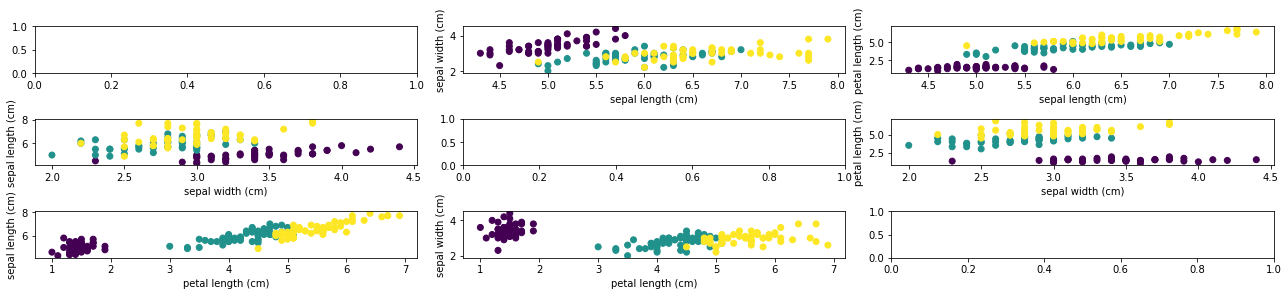

In [5]:
iris = load_iris()

fig, ax = plt.subplots(3, 3, figsize=(18, 4))
fig.subplots_adjust(top=1.5)

for i in range(3):
    for j in range(3):
        
        if i == j:
            continue
            
        # The indices of the features that we are plotting
        x_index = i
        y_index = j

        # this formatter will label the colorbar with the correct target names
        formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])

        ax[i][j].scatter(iris.data[:, x_index], iris.data[:, y_index], c=iris.target)
        ax[i][j].set_xlabel(iris.feature_names[x_index])
        ax[i][j].set_ylabel(iris.feature_names[y_index])

plt.tight_layout()
plt.show()

As we can see the data can indeed be seperated by using these features. 
In order to model this data we'll use GMM with 3 gaussians (as the number of labels). 
But, first we will perform dimension redunction. In order to set a good prior we will use PCA and take the first eigen value.

In [6]:
X = iris['data']

In [81]:
labels = iris['target']

In [7]:
def normalize_data(X):
    avg = np.average(X, axis=0)
    return np.array([x - avg for x in X])

def PCA(X, k):
	"""
	Compute PCA on the given matrix.

	Args:
		X - Matrix of dimesions (n,d). Where n is the number of sample points and d is the dimension of each sample.
		For example, if we have 10 pictures and each picture is a vector of 100 pixels then the dimesion of the matrix would be (10,100).
		k - number of eigenvectors to return

	Returns:
	  U - Matrix with dimension (k,d). The matrix should be composed out of k eigenvectors corresponding to the largest k eigenvectors 
	  		of the covariance matrix.
	  S - k largest eigenvalues of the covariance matrix. vector of dimension (k, 1)
	"""
	normalized_X = normalize_data(X)

	cov_matrix = np.dot(normalized_X.T, normalized_X)
	eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

	eigenvalues_eigenvectors_tuples = zip(eigenvalues, eigenvectors.T)
	sorted_results = sorted(eigenvalues_eigenvectors_tuples, key=lambda x: x[0], reverse=True)
	sorted_eigenvalues, sorted_eigenvectors = zip(*sorted_results)
	S = np.array(sorted_eigenvalues[:k]).reshape(k, 1)
	U = np.array(sorted_eigenvectors[:k])

	return U, S

U, S = PCA(X, 1)
beta_mean_prior = U[0]
beta_variance_prior = S[0][0]
print(beta_mean_prior)

[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]


In [8]:
beta_mean_prior[1] = -beta_mean_prior[1]
for i in range(len(X)):
  X[i][1] = -X[i][1]

# The model

Let's define our model

In [17]:
iris_model = """
data {
  int<lower=0> N; // The number of data points
  int<lower=1> K; // The number of features
  int<lower=1> M; // The number of different iris labels 
  matrix[N,K] X; // The data
  vector[K] pmubeta;  // prior mean for beta
  real psbeta;   // prior variance for beta
}
parameters {
  simplex[K] beta;
  vector<lower = 0>[M] sigma;
  ordered[M] mu;
  simplex[M] theta;  // probability for each component
}
model {
  vector[N] y;  
  beta ~ normal(pmubeta, psbeta);
  mu ~ normal(0, 10);
  sigma ~ normal(0, 1);
  theta ~ dirichlet(rep_vector(2.0, M));
  y = X*beta;
  for(i in 1:N){
      real lp[M];
      for (j in 1:M)
          lp[j] = log(theta[j]) + normal_lpdf(y[i] | mu[j], sigma[j]);
      target += log_sum_exp(lp);
  } 
}
"""

In [18]:
data = {'N': len(X),
        'K': len(X[0]),
        'M': 3,
        'X': X,
        'pmubeta': beta_mean_prior,
        'psbeta': beta_variance_prior}

In [19]:
model = pystan.StanModel(model_code=iris_model)
fit = model.sampling(data=data, iter=10000, chains=4)
samples = fit.extract(permuted=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2c56c2db91dc05a14466db4a608cc880 NOW.


In [20]:
print(fit)

Inference for Stan model: anon_model_2c56c2db91dc05a14466db4a608cc880.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]    0.15  6.6e-4   0.04   0.08   0.12   0.15   0.17   0.22   3274    1.0
beta[2]    0.52  7.9e-4   0.04   0.43    0.5   0.53   0.55   0.59   2481    1.0
beta[3]  5.9e-3  5.3e-5 5.9e-3 1.6e-4 1.7e-3 4.1e-3 8.2e-3   0.02  12388    1.0
beta[4]    0.32  1.3e-3   0.06   0.22   0.28   0.32   0.36   0.47   2433    1.0
sigma[1]   0.16  4.1e-3   0.13    0.1   0.13   0.15   0.16   0.31    935   1.01
sigma[2]   0.15  4.4e-3   0.17   0.03   0.08   0.12   0.16   0.66   1437    1.0
sigma[3]   0.22  6.0e-3   0.21   0.12   0.17   0.18    0.2   0.79   1152    1.0
mu[1]     -1.01    0.02   0.27  -1.47  -1.13   -1.0  -0.86  -0.58    295   1.02
mu[2]     -0.29    0.06   0.41  -1.17  -0.48  -0.19  -0.01   0.32     49    1.1
mu[3]    

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1956a4fd0>,
      dtype=object)

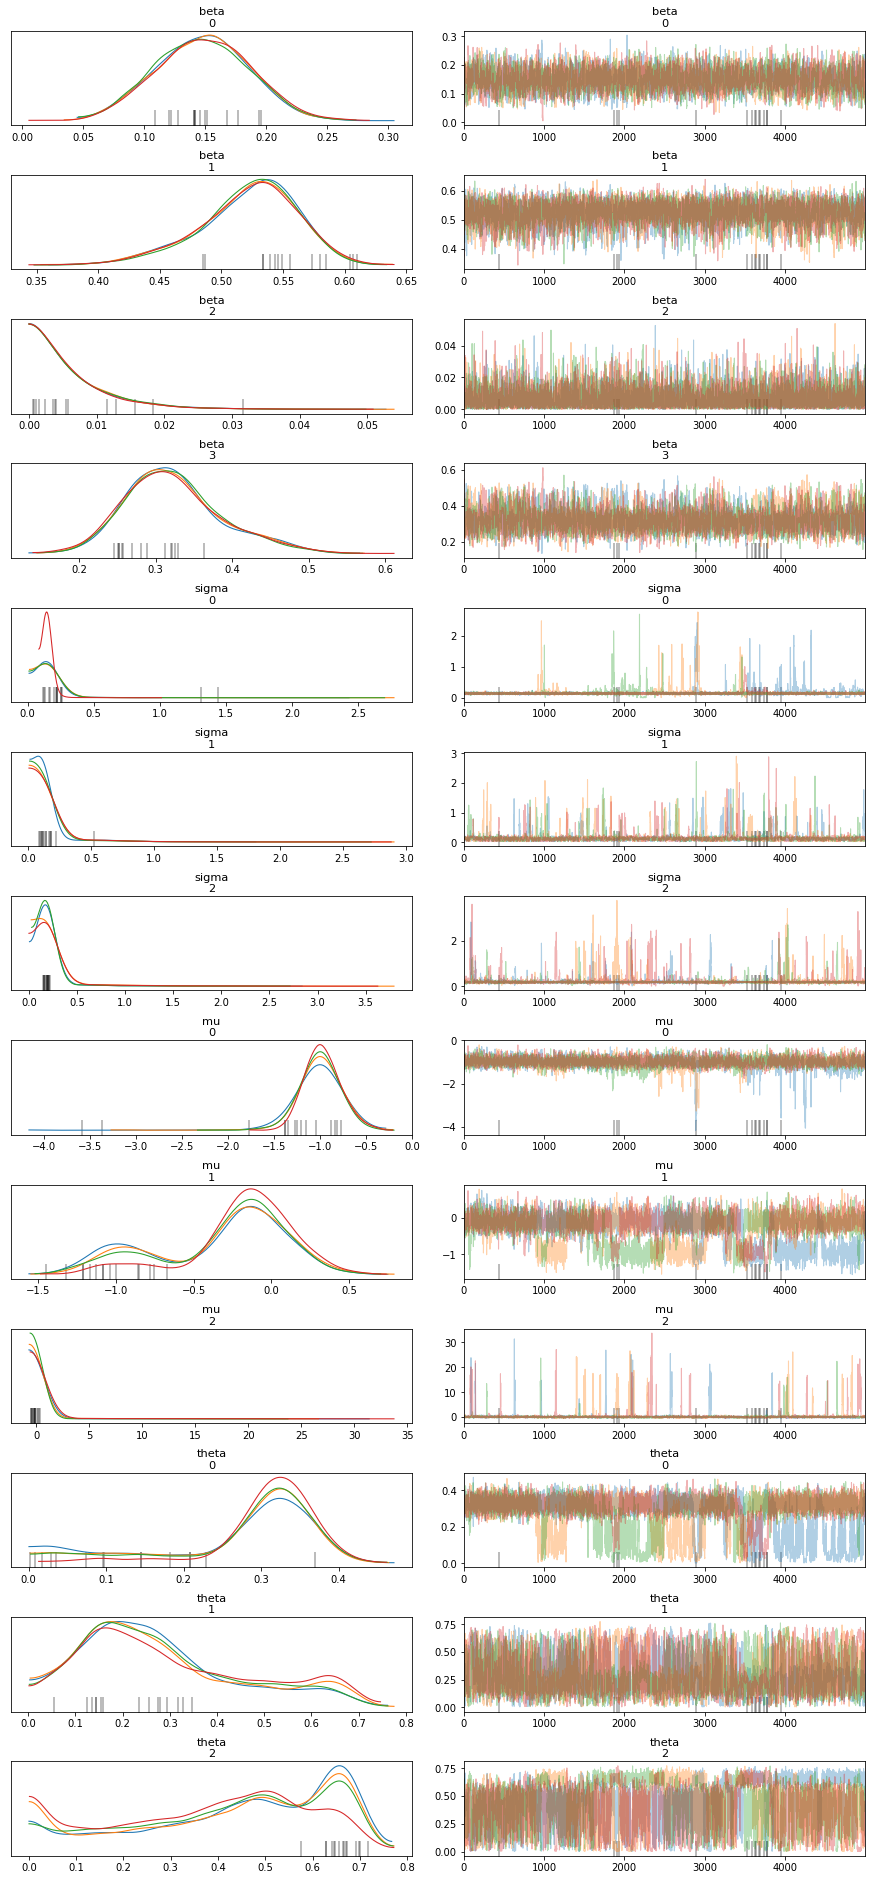

In [21]:
arviz.plot_trace(fit)

We can see that using the features indeed helped to split the data into 3 groups. Looking on the posterior We can see that the data is centerd around -1, 0.3 and one somewhere beteween these values.

/usr/local/lib/python3.6/dist-packages/arviz/utils.py:654: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  ("Keyword argument credible_interval has been deprecated " "Please replace with hdi_prob"),


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1b291def0>,
      dtype=object)

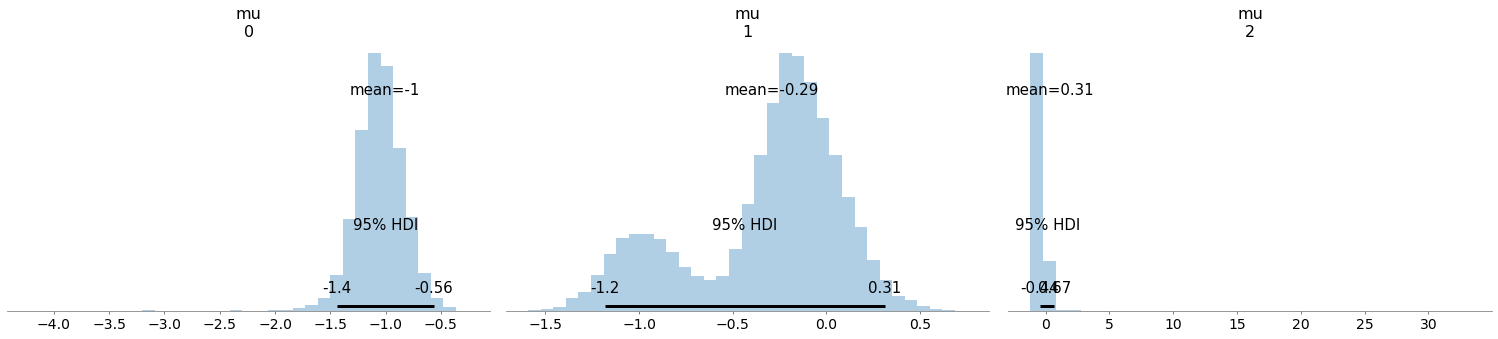

In [23]:
arviz.plot_posterior(fit, var_names=['mu'], credible_interval=0.95, round_to=2, kind='hist', bins=35)

# Model Checking

First of all we will generate y_rep in the following manner:
First, we'll generate theta. Then, we will rand a gausian based on the theta distribution. After that we'll rand y_rep based on the chosen gausian. 

In [57]:
theta = samples['theta']
mu = samples['mu']
sigma = samples['sigma']
beta = samples['beta']
n = len(theta)
y_rep = []
samples_number = len(X)

# Generating y_rep
for i in range(n):
  y_rep_row = []
  for j in range(samples_number):
    group = np.random.choice(range(3), 1, p=theta[0])[0]
    group_mu = mu[i][group]
    group_sigma = sigma[i][group]
    draw = np.random.normal(group_mu, group_sigma, 1)[0]
    y_rep_row.append(draw)
  y_rep.append(y_rep_row)

# transforming the data to 1d
beta_mean = []
for j in range(4):
  beta_mean.append(statistics.mean([b[j] for b in beta]))
beta_vec = np.array(beta_mean)
y = np.dot(X, beta_vec)

[-0.99839223 -0.7670441  -0.90164154 -0.86307355 -1.06539496 -1.09615109
 -0.98784037 -0.96041622 -0.78889752 -0.85105075 -1.0577589  -0.98944294
 -0.81425874 -0.8900815  -1.15687756 -1.31387385 -1.09851907 -0.96598695
 -1.03193493 -1.12197506 -0.89999481 -1.03737641 -1.12700036 -0.79501367
 -0.98766696 -0.75105075 -0.89501367 -0.98299088 -0.9313895  -0.89986556
 -0.83286284 -0.83636824 -1.32855637 -1.30450838 -0.81864547 -0.85780547
 -0.9397468  -1.11260959 -0.84168288 -0.94560687 -0.9813883  -0.42911466
 -0.94606962 -0.88239648 -1.08720181 -0.74944818 -1.15378835 -0.91585891
 -1.07256826 -0.90881485 -0.15203518 -0.20967003 -0.0810619   0.05901555
  0.01450479 -0.16937262 -0.24308349 -0.18339376 -0.08768978 -0.16237271
  0.04137306 -0.18110606  0.08803986 -0.12873929 -0.24170329 -0.14604587
 -0.22375815 -0.20195371  0.28264494 -0.09596439 -0.18472499 -0.11309516
  0.14324217 -0.14135648 -0.11908447 -0.10866185  0.02771157  0.00691531
 -0.11232735 -0.16812166 -0.05917237 -0.09216965 -0

In [59]:
max_y_samples = []
min_y_samples = []
mean_y_samples = []
stdev_y_samples = []
median_y_samples = []
for y_rep_row in y_rep:
  max_y_samples.append(max(y_rep_row))
  min_y_samples.append(min(y_rep_row))
  mean_y_samples.append(statistics.mean(y_rep_row))
  stdev_y_samples.append(statistics.stdev(y_rep_row))
  median_y_samples.append(statistics.median(y_rep_row))

y_dataMax = max(y)
y_dataMin = min(y)
y_dataMean = statistics.mean(y)
y_dataStdev = statistics.stdev(y)
y_dataMedian = statistics.median(y)

Text(0.5, 1.0, 'p-value = 0.73')

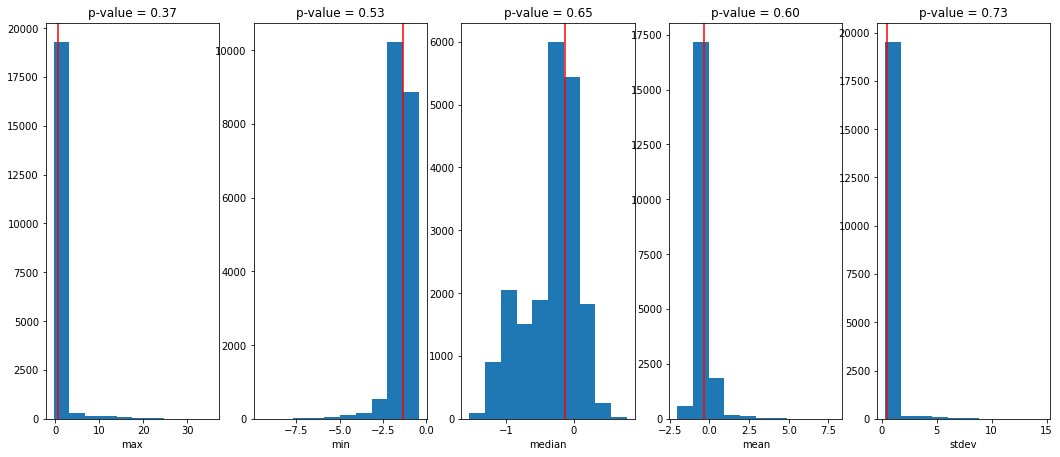

In [60]:
fig, ax = plt.subplots(1, 5, figsize=(18, 4))
fig.subplots_adjust(top=1.5)

number_of_samples = len(max_y_samples)

# Max
ax[0].set_xlabel("max")
ax[0].hist(max_y_samples)
ax[0].axvline(y_dataMax, color="red")
number_of_samples_above_max = len([x for x in max_y_samples if x > y_dataMax])
ax[0].set_title("p-value = {:.2f}".format(number_of_samples_above_max / number_of_samples))

# Min
ax[1].set_xlabel("min")
ax[1].hist(min_y_samples)
ax[1].axvline(y_dataMin, color="red")
number_of_samples_below_min = len([x for x in min_y_samples if x < y_dataMin])
ax[1].set_title("p-value = {:.2f}".format(number_of_samples_below_min / number_of_samples))

# Median
ax[2].set_xlabel("median")
ax[2].hist(median_y_samples)
ax[2].axvline(y_dataMedian, color="red")
number_of_samples_below_median = len([x for x in median_y_samples if x < y_dataMedian])
ax[2].set_title("p-value = {:.2f}".format(number_of_samples_below_median / number_of_samples))

# Mean 
ax[3].set_xlabel("mean")
ax[3].hist(mean_y_samples)
ax[3].axvline(y_dataMean, color="red")
number_of_samples_below_mean = len([x for x in mean_y_samples if x < y_dataMean])
ax[3].set_title("p-value = {:.2f}".format(number_of_samples_below_mean / number_of_samples))

# stdev
ax[4].set_xlabel("stdev")
ax[4].hist(stdev_y_samples)
ax[4].axvline(y_dataStdev, color="red")
number_of_samples_below_stdev = len([x for x in stdev_y_samples if x < y_dataStdev])
ax[4].set_title("p-value = {:.2f}".format(number_of_samples_below_stdev / number_of_samples))

We can see very nice p-values for each of the stats we check.

## Sensitivity analysis

We'll look on mu:



/usr/local/lib/python3.6/dist-packages/arviz/utils.py:654: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  ("Keyword argument credible_interval has been deprecated " "Please replace with hdi_prob"),


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff19425b710>,
      dtype=object)

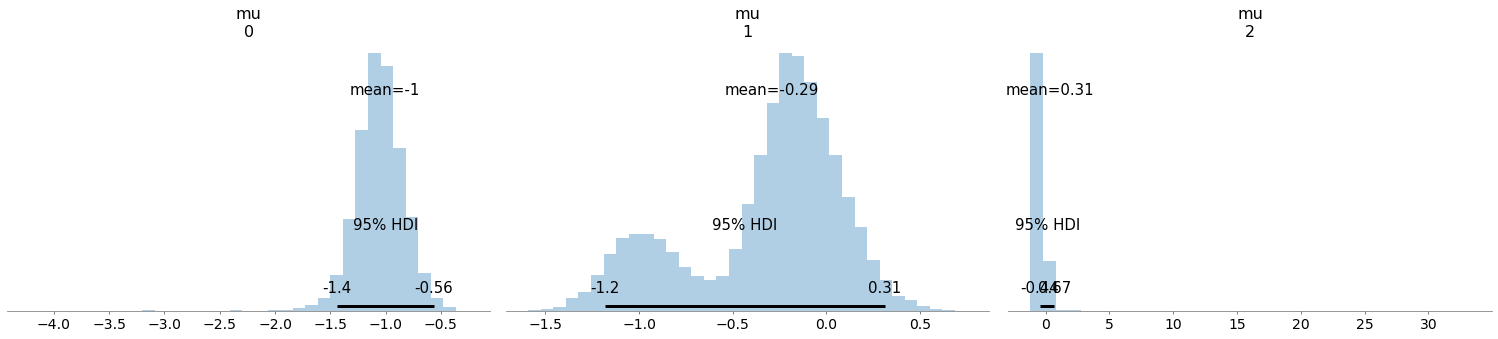

In [61]:
arviz.plot_posterior(fit, var_names=['mu'], credible_interval=0.95, round_to=2, kind='hist', bins=35)

Let's try to change the value of mu_1:

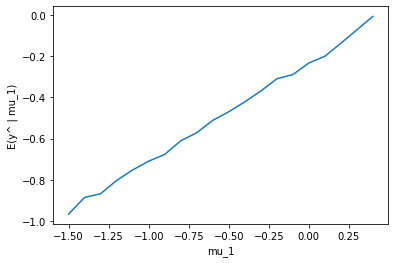

In [71]:
mu_range =  np.arange(-1.5, 0.5, 0.1)
    
mean_array = []

for m in mu_range:
  draws = []
  for i in range(10000):
    group = np.random.choice(range(3), 1, p=theta[0])[0]
    group_mu = m if group == 1 else mu[i][group]
    group_sigma = sigma[i][group]
    draw = np.random.normal(group_mu, group_sigma, 1)[0]
    draws.append(draw)

  mean = statistics.mean(draws)
  mean_array.append(mean)

plt.xlabel("mu_1")
plt.ylabel("E(y^ | mu_1)")
plt.plot(mu_range, mean_array)

Now we can see that expectation of the generated data is sensitive to changes in mu_1, and since mu_1 varies widely, we'll try to define other prior than normal for mu. 

# Alternative model

We'll try to change the prior of t to be student-t.

In [191]:
alternative_iris_model = """
data {
  int<lower=0> N; // The number of data points
  int<lower=1> K; // The number of features
  int<lower=1> M; // The number of different iris labels 
  matrix[N,K] X; // The data
  vector[K] pmubeta;  // prior mean for beta
  real psbeta;   // prior variance for beta
}
parameters {
  simplex[K] beta;
  vector<lower = 0>[M] sigma;
  ordered[M] mu;
  simplex[M] theta;  // probability for each component
  real<lower=1> nu;
}
model {
  vector[N] y;  
  beta ~ normal(pmubeta, psbeta);
  nu ~ gamma(2, 0.1);
  mu ~ student_t(nu, 0, 10);
  sigma ~ normal(0, 1);
  theta ~ dirichlet(rep_vector(2.0, M));
  y = X*beta;
  for(i in 1:N){
      real lp[M];
      for (j in 1:M)
          lp[j] = log(theta[j]) + normal_lpdf(y[i] | mu[j], sigma[j]);
      target += log_sum_exp(lp);
  } 
}
generated quantities {
  vector[N] log_lik;
  real lppd;
  vector[N] y;

  lppd = 0;
  y = X*beta;
  for (i in 1:N) {
      real lp[M];
      for (j in 1:M)
          lp[j] = log(theta[j]) + normal_lpdf(y[i] | mu[j], sigma[j]);
      log_lik[i] = log_sum_exp(lp);
      lppd += log_lik[i];
  }
}
"""

In [192]:
data = {'N': len(X),
        'K': len(X[0]),
        'M': 3,
        'X': X,
        'pmubeta': beta_mean_prior,
        'psbeta': beta_variance_prior
        }

In [193]:
alternative_model = pystan.StanModel(model_code=alternative_iris_model)
alternative_fit = alternative_model.sampling(data=data, iter=10000, chains=4)
second_samples = alternative_fit.extract(permuted=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_99aae011071430f09ff69086905dd73e NOW.


In [194]:
print(alternative_fit)

Inference for Stan model: anon_model_99aae011071430f09ff69086905dd73e.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

                mean se_mean     sd    2.5%     25%     50%     75%  97.5%  n_eff   Rhat
beta[1]         0.15  7.8e-4   0.04    0.07    0.12    0.15    0.17   0.22   2400    1.0
beta[2]         0.52  9.0e-4   0.04    0.43     0.5    0.53    0.55   0.59   1878    1.0
beta[3]       5.9e-3  9.0e-5 5.8e-3  1.6e-4  1.7e-3  4.2e-3  8.3e-3   0.02   4119    1.0
beta[4]         0.33  1.2e-3   0.06    0.22    0.28    0.32    0.36   0.47   2752    1.0
sigma[1]        0.19    0.01   0.17    0.11    0.13    0.15    0.17   0.63    160   1.02
sigma[2]        0.15  4.0e-3   0.16    0.03    0.08    0.12    0.16   0.61   1482    1.0
sigma[3]        0.21  4.0e-3   0.17    0.12    0.16    0.18     0.2    0.6   1876    1.0
mu[1]          -1.06    0.05   0.44   -1.93   -1.15   -1.01   -0.87  -0.58     76   1.06
mu[2]   

/usr/local/lib/python3.6/dist-packages/arviz/plots/traceplot.py:254: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (315), generating only 20 plots
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff17f708c50>,
      dtype=object)

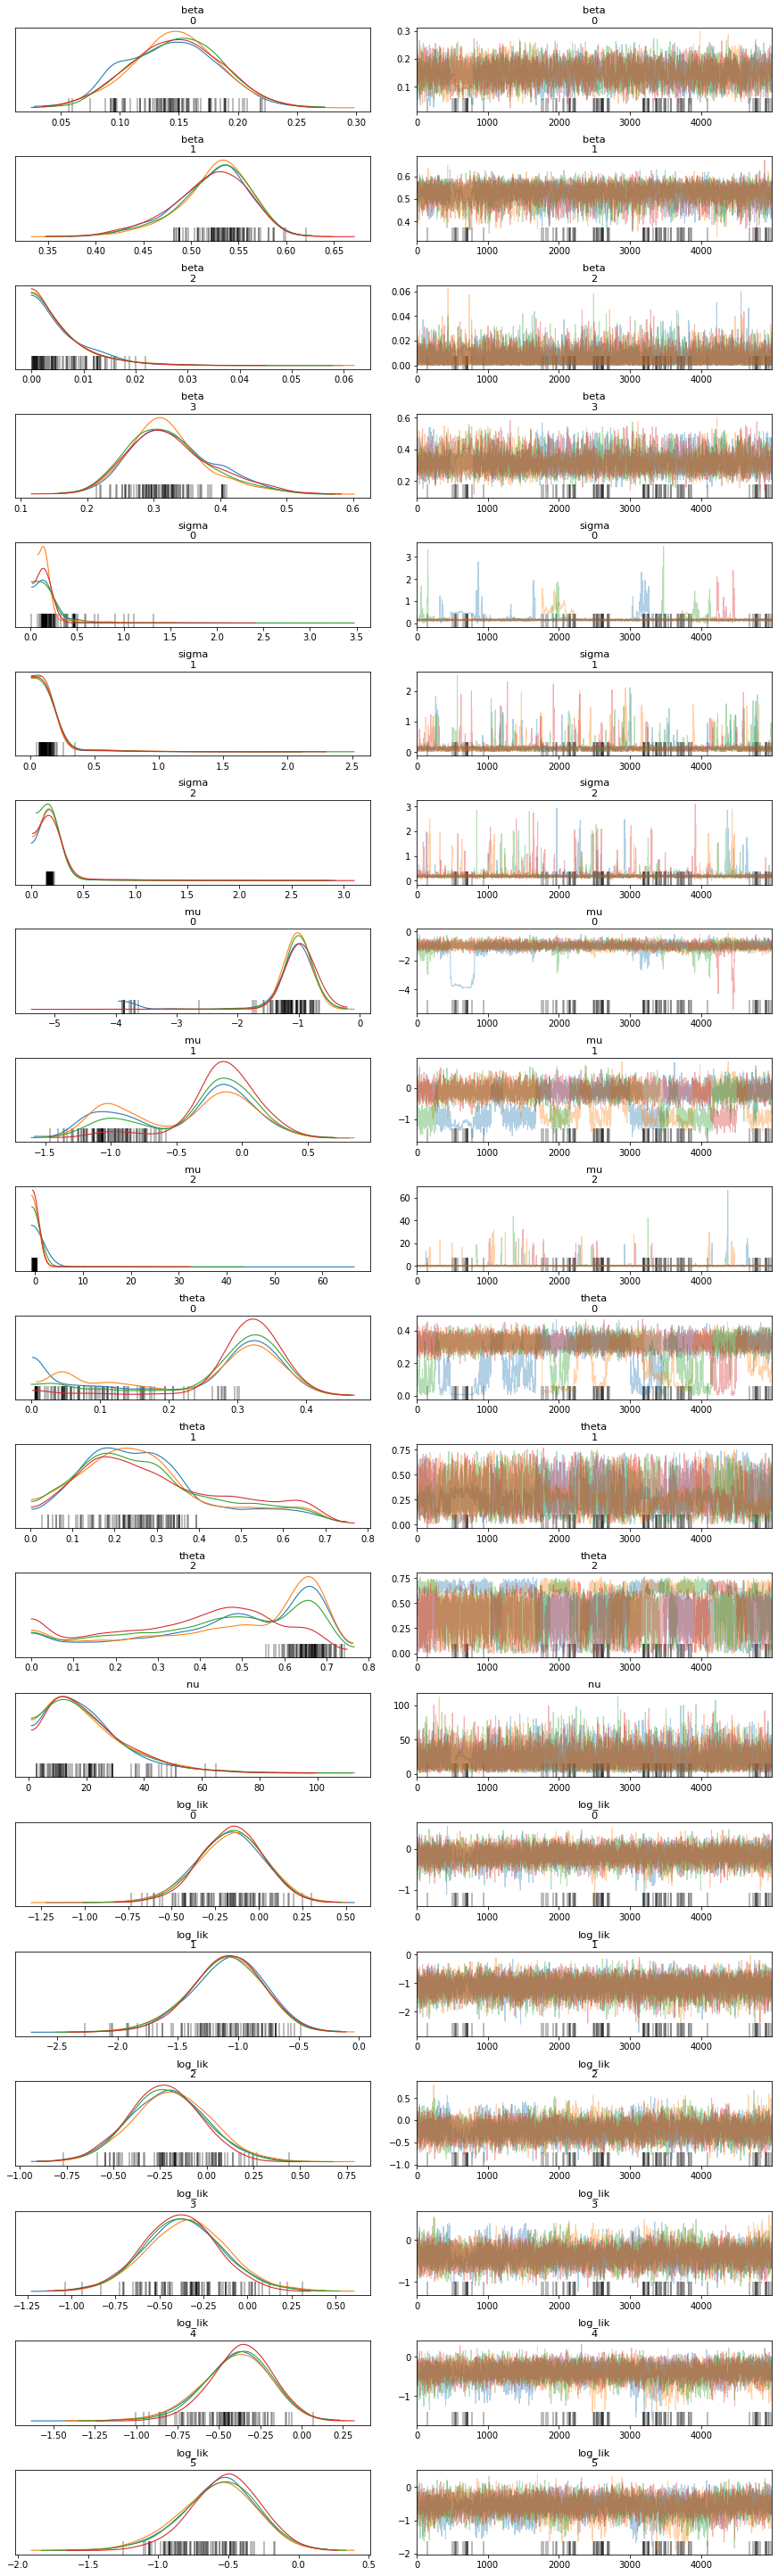

In [195]:
arviz.plot_trace(alternative_fit)

Taking the first model with lppd calculations:

In [169]:
first_iris_model = """
data {
  int<lower=0> N; // The number of data points
  int<lower=1> K; // The number of features
  int<lower=1> M; // The number of different iris labels 
  matrix[N,K] X; // The data
  vector[K] pmubeta;  // prior mean for beta
  real psbeta;   // prior variance for beta
}
parameters {
  simplex[K] beta;
  vector<lower = 0>[M] sigma;
  ordered[M] mu;
  simplex[M] theta;  // probability for each component
}
model {
  vector[N] y;  
  beta ~ normal(pmubeta, psbeta);
  mu ~ normal(0, 10);
  sigma ~ normal(0, 1);
  theta ~ dirichlet(rep_vector(2.0, M));
  y = X*beta;
  for(i in 1:N){
      real lp[M];
      for (j in 1:M)
          lp[j] = log(theta[j]) + normal_lpdf(y[i] | mu[j], sigma[j]);
      target += log_sum_exp(lp);
  } 
}
generated quantities {
  vector[N] log_lik;
  real lppd;
  vector[N] y;

  lppd = 0;
  y = X*beta;
  for (i in 1:N) {
      real lp[M];
      for (j in 1:M)
          lp[j] = log(theta[j]) + normal_lpdf(y[i] | mu[j], sigma[j]);
      log_lik[i] = log_sum_exp(lp);
      lppd += log_lik[i];
  }
}
"""

In [171]:
first_model = pystan.StanModel(model_code=first_iris_model)
first_model_fit = first_model.sampling(data=data, iter=10000, chains=4)
first_samples = first_model_fit.extract(permuted=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0f1daf6ddb18ce5cb373ae1bfc63502b NOW.


In [172]:
print(first_model_fit)

Inference for Stan model: anon_model_0f1daf6ddb18ce5cb373ae1bfc63502b.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

                mean se_mean     sd    2.5%    25%     50%     75%   97.5%  n_eff   Rhat
beta[1]         0.15  6.0e-4   0.04    0.07   0.12    0.15    0.17    0.22   4205    1.0
beta[2]         0.52  6.8e-4   0.04    0.42    0.5    0.52    0.55    0.59   3579    1.0
beta[3]       5.8e-3  5.0e-5 5.9e-3  1.5e-4 1.7e-3  4.0e-3  8.0e-3    0.02  13899    1.0
beta[4]         0.33  1.1e-3   0.07    0.22   0.28    0.32    0.37    0.48   3399    1.0
sigma[1]        0.16  6.0e-3    0.1    0.11   0.13    0.15    0.16    0.22    268   1.02
sigma[2]        0.14  4.0e-3   0.15    0.03   0.07    0.12    0.16     0.6   1413    1.0
sigma[3]        0.22  5.4e-3   0.21    0.12   0.16    0.18     0.2    0.82   1459    1.0
mu[1]          -0.98    0.01   0.23   -1.39  -1.11   -0.98   -0.85   -0.56    457   1.01
mu[2]   

We'll evaluate eack of the models using WAIC:

In [196]:
waic_2_model_1 = 0
log_lik = first_samples['log_lik']

for n in range(len(log_lik[0])):
  variance = np.var([log_lik[s][n] for s in range(len(log_lik))])
  waic_2_model_1 = waic_2_model_1 + variance
lppd_model_1 = statistics.mean(first_samples['lppd'])

waic_2_model_2 = 0
log_lik = second_samples['log_lik']
for i in range(len(log_lik[0])):
  variance = np.var([log_lik[s][n] for s in range(len(log_lik))])
  waic_2_model_2 = waic_2_model_2 + variance
lppd_model_2 = statistics.mean(second_samples['lppd'])

waic_value_model_1 = -2*lppd_model_1 + 2*waic_2_model_1
waic_value_model_2 = -2*lppd_model_2 + 2*waic_2_model_2

from tabulate import tabulate
print(tabulate([['Model 1', lppd_model_1, waic_2_model_1, waic_value_model_1], ['Model 2', lppd_model_2, waic_2_model_2, waic_value_model_2]], headers=['Model', 'lppd', 'p_waic_2', 'waic']))


Model        lppd    p_waic_2     waic
-------  --------  ----------  -------
Model 1  -38.4958    12.8074   102.606
Model 2  -38.6587     6.11232   89.542


So, as we can see the second model produces us a better WAIC result, so by this citeria we will prefer to use the second model.